In [16]:
import re 

import numpy as np
import pandas as pd
import xarray as xr

from scipy import signal, stats

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.gridspec import GridSpec

from shapely import geometry
from src import nino34, precip, utils

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
                                
import cmaps 
from datetime import datetime

import gcgridobj 

from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# DEFINE DIRECTORIES HERE
ERSST_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/"
HADIS_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/"
COBES_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/"

GPCC_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/"
CRUT_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/"
APHR_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/"

In [3]:
# Open global SST datasets
sst_E = utils.get_ds(
    f'{ERSST_DIR}/sst.mnmean.v5.nc'
)

sst_H = utils.get_ds(
    f'{HADIS_DIR}/HadISST_sst.nc'
)

sst_C = utils.get_ds(
    f'{COBES_DIR}/sst.mon.mean.nc'
)


sst_E = sst_E['sst'].sel(time=slice("1951-01", "2015-12"))
sst_H = sst_H['sst'].sel(time=slice("1951-01", "2015-12"))
sst_C = sst_C['sst'].sel(time=slice("1951-01", "2015-12"))


In [4]:
sst_E_qs = sst_E.resample(time='QS-DEC', label='left').mean()
sst_H_qs = sst_H.resample(time='QS-DEC', label='left').mean()
sst_C_qs = sst_C.resample(time='QS-DEC', label='left').mean()


In [5]:
sst_E_djf = sst_E_qs.sel(time=sst_E_qs.time.dt.month.isin([12])).resample(time='1Y').mean()
sst_H_djf = sst_H_qs.sel(time=sst_H_qs.time.dt.month.isin([12])).resample(time='1Y').mean()
sst_C_djf = sst_C_qs.sel(time=sst_C_qs.time.dt.month.isin([12])).resample(time='1Y').mean()


In [6]:
sst_unique = [
    sst_E_djf,
    sst_H_djf,
    sst_C_djf
]

time = sst_E_djf.time.values
lat = sst_E_djf['lat'].values
lon = sst_E_djf['lon'].values


dst_grid = gcgridobj.latlontools.extract_grid(sst_E_djf.to_dataset(name='sst'))

sst_unique_regridded = []
for i, (sst_unique) in enumerate(sst_unique):
    ds = sst_unique.sel(time=slice("1951-01", "2015-12"))

    src_grid = gcgridobj.latlontools.extract_grid(sst_unique.to_dataset(name='sst'))
    regridder = gcgridobj.regrid.gen_regridder(src_grid, dst_grid)
    da_regridded = regridder(sst_unique)
    sst_da = xr.DataArray(da_regridded, coords={'time': time, 'lat': lat, 
                                    'lon': lon},
                dims=['time', 'lat', 'lon'])
    sst_unique_regridded.append(sst_da) 

In [7]:
sst_djf_all = xr.concat(sst_unique_regridded, dim='dataset')
sst_djf_mean = sst_djf_all.mean(dim='dataset')

In [8]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [9]:
def process_member(ens):
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc")
    return sst_da
    
def main(members):
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        sst_anm = result
        all_ssts.append(sst_anm)
    return all_ssts

global_all_ssts = main(members)

In [10]:
global_ssts_ds_DJF = xr.concat(global_all_ssts, dim='ensemble')
global_ssts_da_DJF = global_ssts_ds_DJF['SST'].isel(z_t=0, drop=True).sel(time=slice('1900-01','2100-12'))


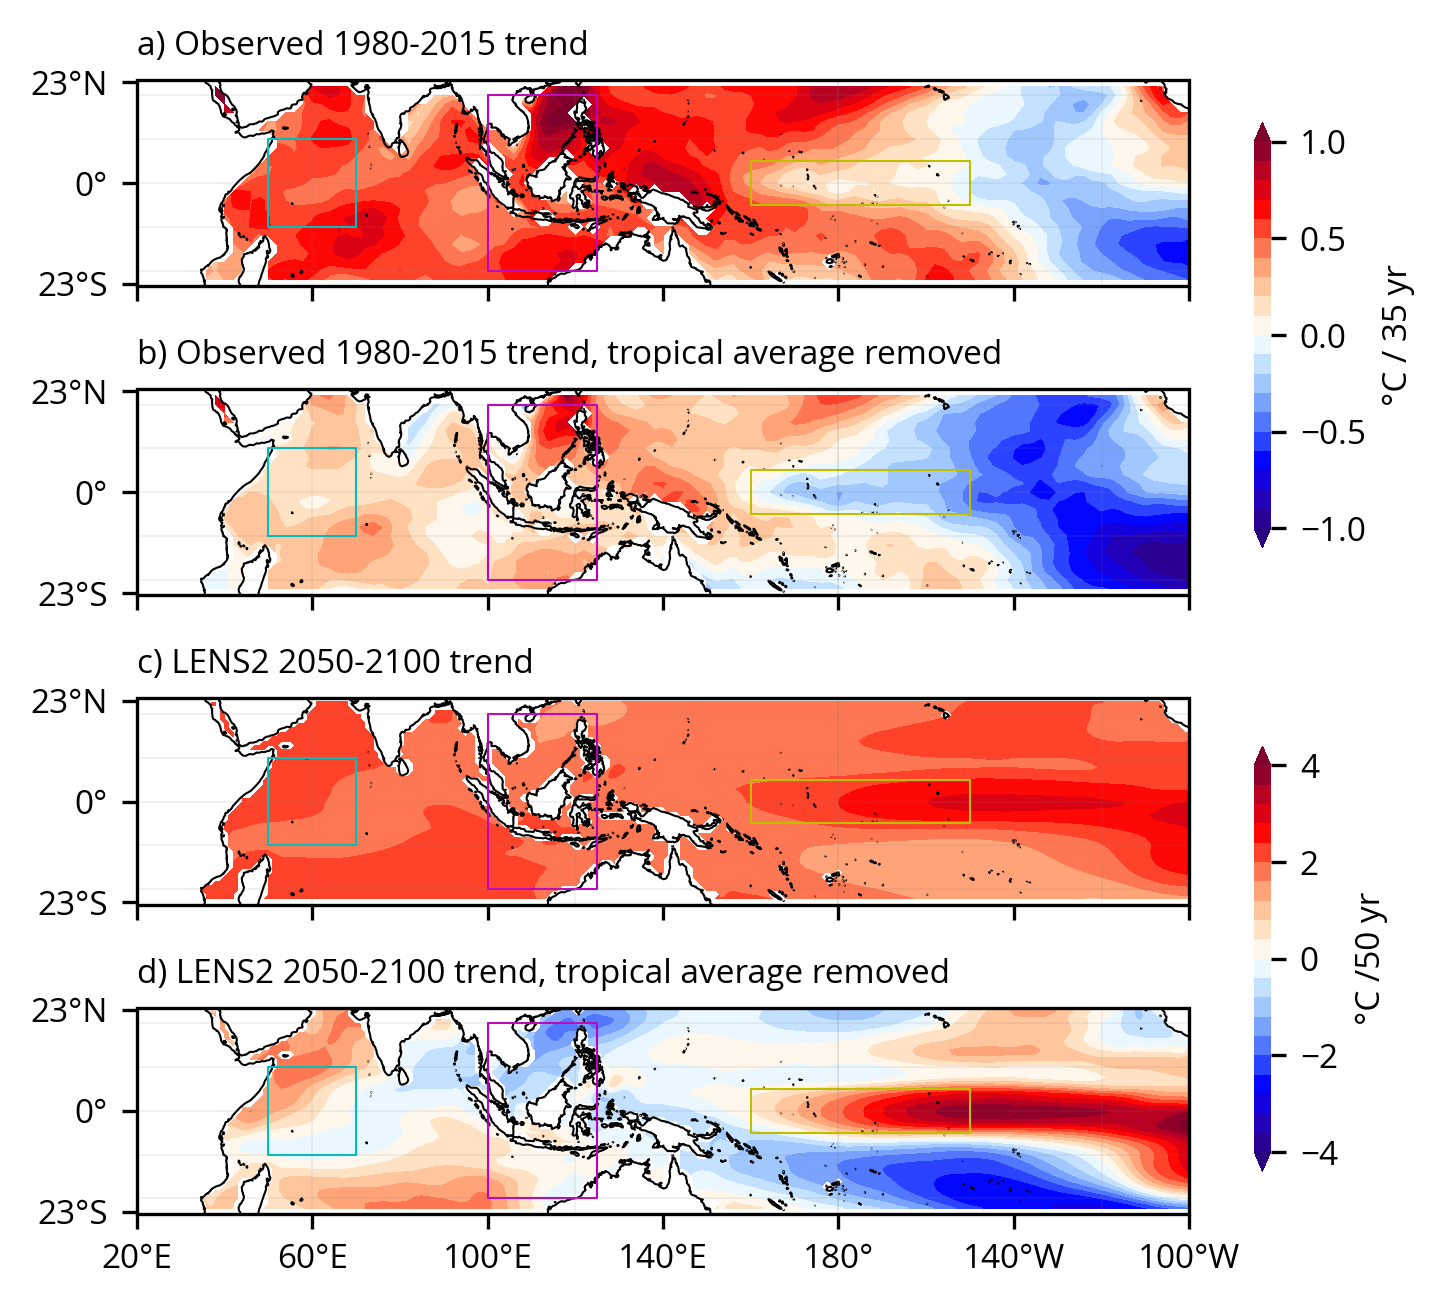

In [17]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")

color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 14
fig_height_cm = 12
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=False)

gs1 = GridSpec(4, 1, top=0.90, bottom=0.10, hspace=0.5, wspace=0.2)

ax2 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[3, 0], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 4b #############
ax1.set_title("b) Observed 1980-2015 trend, tropical average removed", loc="left")

sst_djf_tropics = sst_djf_mean.sel(lat=slice(-23, 23)).sel(time=slice('1980','2015'))
relative = sst_djf_tropics - sst_djf_tropics.mean(dim=['lat', 'lon']) 
sst = utils.mask_land(relative)

sst['time'] = np.arange(1980,2016,1)
trend = sst.polyfit(dim='time', deg=1)
slope = trend.polyfit_coefficients.isel(degree=0)

levels = np.linspace(-1, 1, 21)

trend_plot = ax1.contourf(
    slope['lon'], slope['lat'], slope*35,
    cmap=cmaps.NCV_blu_red,
    levels=levels,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.CenteredNorm(),
    extend='both'
)

############## Figure 4a #############
ax2.set_title("a) Observed 1980-2015 trend", loc="left")

sst = sst_djf_tropics
sst = utils.mask_land(sst)

sst['time'] = np.arange(1980,2016,1)
trend = sst.polyfit(dim='time', deg=1)
slope = trend.polyfit_coefficients.isel(degree=0)

levels = np.linspace(-1, 1, 21)

trend_plot = ax2.contourf(
    slope['lon'], slope['lat'], slope*35,
    cmap=cmaps.NCV_blu_red,
    levels=levels,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.CenteredNorm(),
    extend='both'
)


# Add colorbar
cbar_ax = fig.add_axes([0.87, 0.57, 0.01, 0.3])  # [left, bottom, width, height]

cbar = fig.colorbar(trend_plot,  cax=cbar_ax, orientation="vertical", shrink=0.80, label='°C / 35 yr')
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)
ticks = np.linspace(-1, 1, num=5)  # Adjust 'num' for the number of ticks you want
cbar.set_ticks(ticks)


############## Figure 4d #############
ax3.set_title("d) LENS2 2050-2100 trend, tropical average removed", loc="left")

sst_djf_tropics_model = global_ssts_da_DJF.sel(lat=slice(-23, 23)).sel(time=slice('2050','2100'))
relative = sst_djf_tropics_model - sst_djf_tropics_model.mean(dim=['lat', 'lon']) 
sst = relative.mean(dim='ensemble')
sst = utils.mask_land(sst)

sst['time'] = np.arange(2050,2101,1)
trend = sst.polyfit(dim='time', deg=1)
slope = trend.polyfit_coefficients.isel(degree=0)

levels = np.linspace(-1, 1, 21)

trend_plot = ax3.contourf(
    slope['lon'], slope['lat'], slope*50,
    cmap=cmaps.NCV_blu_red,
    levels=levels,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.CenteredNorm(),
    extend='both'
)

############## Figure 4c #############
ax4.set_title("c) LENS2 2050-2100 trend", loc="left")

sst = sst_djf_tropics_model.mean(dim='ensemble')
sst = utils.mask_land(sst)

sst['time'] = np.arange(2050,2101,1)
trend = sst.polyfit(dim='time', deg=1)
slope = trend.polyfit_coefficients.isel(degree=0)

levels = np.linspace(-4, 4, 21)

trend_plot = ax4.contourf(
    slope['lon'], slope['lat'], slope*50,
    cmap=cmaps.NCV_blu_red,
    levels=levels,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.CenteredNorm(),
    extend='both'
)

cbar_ax = fig.add_axes([0.87, 0.13, 0.01, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(trend_plot,  cax=cbar_ax, orientation="vertical", shrink=0.80, label='°C /50 yr')
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)
ticks = np.linspace(-4, 4, num=5)  # Adjust 'num' for the number of ticks you want
cbar.set_ticks(ticks)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
axs = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(axs):
    ax.set_yticks([-23, 0, 23], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-23, 0, 23], fontsize=8)
    ax.tick_params(axis='y', which='major', labelsize=8)  # Set tick params for each ax
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260], crs=ccrs.PlateCarree())
    ax.set_xticklabels([], fontsize=8)
    ax.set_extent([20, 260, -23.5, 23.5], crs=ccrs.PlateCarree())
    ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
        )
    ax.coastlines(linewidth=0.5)
    #ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.LAND, facecolor='white')


    # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
    geom = geometry.box(minx=50, maxx=70, miny=-10, maxy=10)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='c', facecolor='none', linewidth=0.5)

    # Central: 100–125°E, -20°S–20°N)
    geom = geometry.box(minx=100, maxx=125, miny=-20, maxy=20)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='m', facecolor='none', linewidth=0.5)

    # Western Pacific: 5S-5N and 140E-180W.
    geom = geometry.box(minx=160, maxx=210, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='y', facecolor='none', linewidth=0.5)

ax3.set_xticklabels([20, 60, 100, 140, 180, 220, 260], fontsize=8)
ax3.xaxis.set_major_formatter(lon_formatter)

plt.tight_layout()
plt.savefig("Fig4.png")
